In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy import sparse
import math

In [2]:
anime_ratings_df = pd.read_csv("rating.csv")
anime_ratings_df.shape
print(anime_ratings_df.head())

   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1


In [3]:
anime_ratings = anime_ratings_df.loc[anime_ratings_df.rating != -1].reset_index()[['user_id','anime_id','rating']]
print(anime_ratings.shape)
anime_ratings.head()

(6337241, 3)


,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10


array([[<Axes: title={'center': 'rating'}>]], dtype=object)

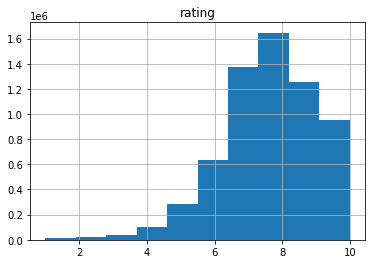

In [4]:
anime_ratings.hist(column = 'rating')

In [5]:
np.mean(anime_ratings.groupby(['user_id']).count()['anime_id'])

91.05231321839081

In [6]:
train_df, valid_df = train_test_split(anime_ratings, test_size=0.2)
train_df = train_df.reset_index()[['user_id', 'anime_id', 'rating']]
valid_df = valid_df.reset_index()[['user_id', 'anime_id', 'rating']]

In [7]:
def encode_column(column):
    """ Encodes a pandas column with continous IDs"""
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id, np.array([key_to_id[x] for x in column]), len(keys)

In [8]:
def encode_df(anime_df):
    """Encodes rating data with continuous user and anime ids"""

    anime_ids, anime_df['anime_id'], num_anime = encode_column(anime_df['anime_id'])
    user_ids, anime_df['user_id'], num_users = encode_column(anime_df['user_id'])
    return anime_df, num_users, num_anime, user_ids, anime_ids

In [9]:
anime_df, num_users, num_anime, user_ids, anime_ids = encode_df(train_df)
print("Number of users :", num_users)
print("Number of anime :", num_anime)
anime_df.head()

Number of users : 68850
Number of anime : 9743


,user_id,anime_id,rating
0,0,0,7
1,1,1,7
2,2,2,7
3,3,3,7
4,4,4,8


In [10]:
# n: number of items/users
# K: number of factors in the embedding
def create_embeddings(n, K):
    return 11*np.random.random((n, K)) / K

In [11]:
def create_sparse_matrix(df, rows, cols, column_name="rating"):
    return sparse.csc_matrix((df[column_name].values,(df['user_id'].values, df['anime_id'].values)),shape=(rows, cols))

In [12]:
anime_df, num_users, num_anime, user_ids, anime_ids = encode_df(train_df)
Y = create_sparse_matrix(anime_df, num_users, num_anime)

In [13]:
Y.todense()

matrix([[7, 0, 0, ..., 0, 0, 0],
        [0, 7, 0, ..., 0, 0, 0],
        [0, 0, 7, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [14]:
# Computes df["prediction"] by using elementwise multiplication of the corresponding embeddings and then
# sum to get the prediction u_i*v_j
def predict(df, emb_user, emb_anime):
    df['prediction'] = np.sum(np.multiply(emb_anime[df['anime_id']],emb_user[df['user_id']]), axis=1)
    return df

In [15]:
lmbda = 0.0002

In [16]:
def cost(df, emb_user, emb_anime):
    Y = create_sparse_matrix(df, emb_user.shape[0], emb_anime.shape[0])
    predicted = create_sparse_matrix(predict(df, emb_user, emb_anime), emb_user.shape[0], emb_anime.shape[0], 'prediction')
    return math.sqrt(np.sum((Y-predicted).power(2))/df.shape[0])

In [17]:
def gradient(df, emb_user, emb_anime):
    Y = create_sparse_matrix(df, emb_user.shape[0], emb_anime.shape[0])
    predicted = create_sparse_matrix(predict(df, emb_user, emb_anime), emb_user.shape[0], emb_anime.shape[0], 'prediction')
    delta =(Y-predicted)
    grad_user = (-2/df.shape[0])*(delta*emb_anime) + 2*lmbda*emb_user
    grad_anime = (-2/df.shape[0])*(delta.T*emb_user) + 2*lmbda*emb_anime
    return grad_user, grad_anime

In [18]:
# emb_user: the trained user embedding
# emb_anime: the trained anime embedding
def gradient_descent(df, emb_user, emb_anime, iterations=2000, learning_rate=0.01, df_val=None):
    Y = create_sparse_matrix(df, emb_user.shape[0], emb_anime.shape[0])
    beta = 0.9
    grad_user, grad_anime = gradient(df, emb_user, emb_anime)
    v_user = grad_user
    v_anime = grad_anime
    for i in range(iterations):
        grad_user, grad_anime = gradient(df, emb_user, emb_anime)
        v_user = beta*v_user + (1-beta)*grad_user
        v_anime = beta*v_anime + (1-beta)*grad_anime
        emb_user = emb_user - learning_rate*v_user
        emb_anime = emb_anime - learning_rate*v_anime
        if(not (i+1)%50):
            print("\niteration", i+1, ":")
            print("train rmse:",  cost(df, emb_user, emb_anime))
            if df_val is not None:
                print("validation rmse:",  cost(df_val, emb_user, emb_anime))
    return emb_user, emb_anime

In [19]:
emb_user = create_embeddings(num_users, 5)
emb_anime = create_embeddings(num_anime, 5)
emb_user, emb_anime = gradient_descent(anime_df, emb_user, emb_anime, iterations=800, learning_rate=1)


iteration 50 :
train rmse: 2.8764236642425343

iteration 100 :
train rmse: 2.730261813681435

iteration 150 :
train rmse: 2.6429648310995635

iteration 200 :
train rmse: 2.5813871739014114

iteration 250 :
train rmse: 2.534682937207157

iteration 300 :
train rmse: 2.4979668080549335

iteration 350 :
train rmse: 2.4686135659339112

iteration 400 :
train rmse: 2.4450354654759945

iteration 450 :
train rmse: 2.4261855187646777

iteration 500 :
train rmse: 2.4113252932676907

iteration 550 :
train rmse: 2.3999049482788464

iteration 600 :
train rmse: 2.391496467858716

iteration 650 :
train rmse: 2.3857542905799924

iteration 700 :
train rmse: 2.3823909900998155

iteration 750 :
train rmse: 2.381161661883713

iteration 800 :
train rmse: 2.3818535628774824


In [21]:
def encode_new_data(valid_df, user_ids, anime_ids):
    df_val_chosen = valid_df['anime_id'].isin(anime_ids.keys()) & valid_df['user_id'].isin(user_ids.keys())
    valid_df = valid_df[df_val_chosen]
    valid_df['anime_id'] =  np.array([anime_ids[x] for x in valid_df['anime_id']])
    valid_df['user_id'] = np.array([user_ids[x] for x in valid_df['user_id']])
    return valid_df

In [22]:
print("before encoding:", valid_df.shape)
valid_df = encode_new_data(valid_df, user_ids, anime_ids)
print("after encoding:", valid_df.shape)

before encoding: (1267449, 3)
after encoding: (748544, 3)


In [23]:
train_rmse = cost(train_df, emb_user, emb_anime)
val_rmse = cost(valid_df, emb_user, emb_anime)
print(train_rmse, val_rmse)

2.3818535628774824 4.03836971145614


In [50]:
valid_df.head()

,user_id,anime_id,rating,prediction
0,59759,740,8,6.387917
1,53281,1366,8,3.959869
2,58604,6676,8,2.680622
3,62469,3455,6,4.088992
5,4842,449,7,6.198959
